# Inference with MedSAM

This notebook demonstrates the inference process for segmenting anatomical structures and lesions in various medical images using the **MedSAM** model. MedSAM is a foundational model designed for medical image segmentation, developed from the Segment Anything Model (SAM) and fine-tuned with a vast medical dataset.

The goal of this notebook is to:
- Load a pre-trained MedSAM model.
- Perform segmentation
- Visualize the segmentation results.

#### DISCLAIMER
All code provided in this file comes directly from the [paper’s repository](https://github.com/bowang-lab/MedSAM). The purpose here is not to recreate the provided code, but to compile it with relevant information for presentation.

For more details, see the original article: [MedSAM: Segment anything in medical images](https://www.nature.com/articles/s41467-024-44824-z).

>@article{MedSAM,
  title={Segment Anything in Medical Images},  
  author={Ma, Jun and He, Yuting and Li, Feifei and Han, Lin and You, Chenyu and Wang, Bo},  
  journal={Nature Communications},  
  volume={15},  
  pages={654},  
  year={2024}  
}

## Architecture

MedSAM employs an architecture composed of:
- **Image encoder (Vision Transformer)**: Extracts image features;
- **Prompt encoder**: Integrates user interactions (bounding boxes);
- **Mask decoder**: Generates segmentation results and confidence scores using image embeddings, prompt embeddings, and output tokens.



# Environment Setup

In [1]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import libraries and define necessary functions

In [2]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


## Download checkpoints and Dataset

In [3]:

!wsl wget -O img_demo.png https://raw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
!wsl wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2025-09-26 16:17:14--  https://raw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87865 (86K) [image/png]
Saving to: ‘img_demo.png’

     0K .......... .......... .......... .......... .......... 58% 2.17M 0s
    50K .......... .......... .......... .....                100% 11.3M=0.03s

2025-09-26 16:17:14 (3.27 MB/s) - ‘img_demo.png’ saved [87865/87865]

--2025-09-26 16:17:14--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]


# Check paths

In [ ]:
#%% load model and image
MedSAM_CKPT_PATH = "./medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()



C:\Users\jvoli\AppData\Roaming\Python\Python311\site-packages\segment_anything\build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map

# Run Inference

In [17]:
def run_and_show_inference(img_path, box_np):
    img_np = io.imread(img_path)
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    H, W, _ = img_3c.shape

    #%% image preprocessing and model inference
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)


    # transfer box_np t0 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

    #%% visualize results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_3c)
    show_box(box_np[0], ax[0])
    ax[0].set_title("Input Image and Bounding Box")
    ax[1].imshow(img_3c)
    show_mask(medsam_seg, ax[1])
    show_box(box_np[0], ax[1])
    ax[1].set_title("MedSAM Segmentation")
    plt.show()

# Show Results

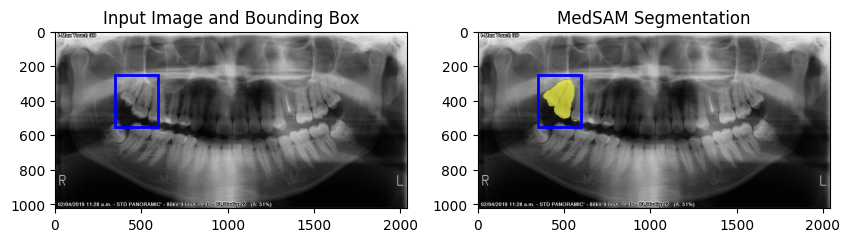

In [47]:
# Example 1:
# run_and_show_inference('img_demo.png', np.array([[95,255, 190, 350]]))

# Image source: https://www.jsrt.or.jp/jsrt-db/en/
# Example 2:
# run_and_show_inference('jsrt_demo_JPCLN079.png', np.array([[250,50, 1000, 1500]]))

# Image source: https://www.jsrt.or.jp/jsrt-db/en/
# Example 3:
# run_and_show_inference('jsrt_demo_JPCLN079.png', np.array([[800,500, 1300, 1300]]))

# Image source: https://www.kaggle.com/datasets/humansintheloop/teeth-segmentation-on-dental-x-ray-images
# Example 4:
run_and_show_inference('teeth_demo_104.jpg', np.array([[350,250, 600, 550]]))